# Analyse de la densité d'états des phonons

In [6]:
from mp_api.client import MPRester
from pymatgen.phonon.plotter import PhononBSPlotter
import numpy as np
import matplotlib.pyplot as plt
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from scipy.optimize import minimize
from scipy.integrate import quad

In [7]:
mp_key = "fShF0m8lEepeLAjHYRHR50cMgpJGq7yr"
mp_id = "mp-16763"
with MPRester(mp_key) as m:
    structure = m.get_structure_by_material_id(mp_id)
    dos = m.get_phonon_dos_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

## Température de Debye et Einstein 
En minimisant l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique.

In [8]:
N_at = len(structure)  # nombre d'atomes dans la maille
R = 8.314               # constante des gaz parfaits (J/mol·K)
k_B = 1.380649e-23      # constante de Boltzmann (J/K)
hbar = 1.0545718e-34    # constante de Planck réduite (J·s)
toTHz = 1e-12           # conversion en THz

True_T = np.arange(5, 1000, 5)
Cv = np.array([dos.cv(T) / (3 * N_at * R) for T in True_T])

In [9]:
# Ajustement du modèle d’Einstein
def Einstein(T, theta_E):
    exp = np.exp(theta_E / T)
    return (theta_E / T)**2 * (exp / (exp - 1)**2)

def error_Einstein(theta_E):
    Cv_E = Einstein(True_T, theta_E)
    return np.sum((Cv - Cv_E)**2)

theta_E_opt = minimize(error_Einstein, 200).x[0]
print(f"Température d’Einstein optimale : {theta_E_opt:.2f} K")

Température d’Einstein optimale : 146.13 K


In [10]:
# Ajustement du modèle de Debye

def integrand(x):
    exp = np.exp(x)
    return (x**4 * exp) / ((exp - 1)**2)

def Debye(T, theta_D):
    integral, _ = quad(integrand, 0, theta_D / T)
    return 3 * (T / theta_D)**3 * integral

def error_Debye(theta_D):
    return np.sum([(Debye(T, theta_D) - Cv[i])**2 for i, T in enumerate(True_T)])

theta_D_opt = minimize(error_Debye, 200).x[0]
print(f"Température de Debye optimale : {theta_D_opt:.2f} K")


Température de Debye optimale : 197.58 K


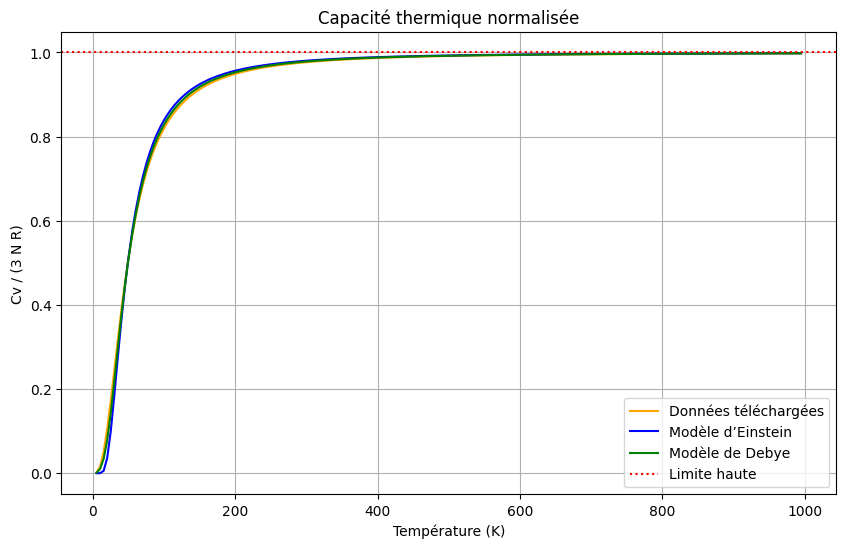

In [15]:
Cv_E = Einstein(True_T, theta_E_opt)
Cv_D = np.array([Debye(T, theta_D_opt) for T in True_T])

plt.figure(figsize=(10, 6))
plt.plot(True_T, Cv, label="Données téléchargées", color='orange')
plt.plot(True_T, Cv_E, label="Modèle d’Einstein", color='blue')
plt.plot(True_T, Cv_D, label="Modèle de Debye", color='green')
plt.axhline(1, linestyle='dotted', color='red', label="Limite haute")
plt.xlabel("Température (K)")
plt.ylabel("Cv / (3 N R)")
plt.title("Capacité thermique normalisée")
plt.legend()
plt.grid(True)
plt.show()


## Densité d'états de phonons

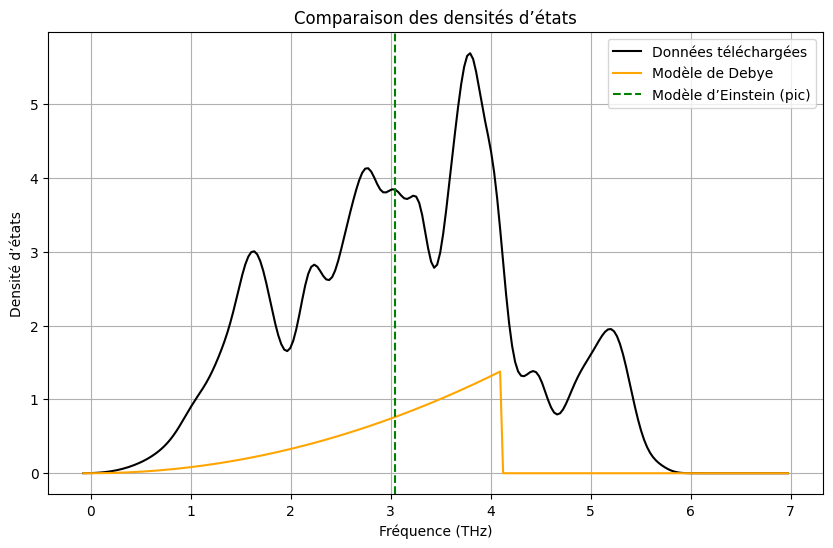

In [12]:
freq = dos.frequencies
dens = dos.densities
omega = 2 * np.pi * freq

omega_E = toTHz * theta_E_opt * k_B / hbar
omega_D = toTHz * theta_D_opt * k_B / hbar

dens_D = np.array([(9 * N_at * o**2 / omega_D**3) if o < omega_D else 0 for o in omega])

plt.figure(figsize=(10, 6))
plt.plot(freq, dens, color='black', label="Données téléchargées")
plt.plot(freq, dens_D, color='orange', label="Modèle de Debye")
plt.axvline(omega_E / (2*np.pi), color='green', linestyle='--', label="Modèle d’Einstein (pic)")
plt.xlabel("Fréquence (THz)")
plt.ylabel("Densité d’états")
plt.title("Comparaison des densités d’états")
plt.legend()
plt.grid(True)
plt.show()
